# Classification and Regression of astronomical sources using multi-wavelength photometric data and machine learning

Chaka Mofokeng <br>
email: mofokeng.chk@gmail.com <br>
github: https://github.com/Mofokeng-C/

This is a tutorial that uses two machine learning algorithms: random forest and k-nearest neighbor classifiers. It uses corrected photometric magnitudes from SDSS together with corresponding WISE magnitudes, which are used to disentangle three different classes (stars, galaxies and quasars) and also estimate photometric redshifts by using colour magnitudes as features to learn.

This tutorial was developed using some of the code from sci-kit learn tutorials ([http://scikit-learn.org/stable/tutorial/index.html](http://url))

In [1]:
# Loading necessary modlules

import os 
import os.path as osp
import itertools
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as pl
pl.rcParams['axes.labelsize'] = 16
pl.rcParams['axes.titlesize'] = 16

import pandas as pd
import seaborn as sns
import timeit
#import verstack

from astropy.stats import bayesian_blocks
from scipy.stats import binned_statistic,norm, bayes_mvs
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import gaussian_kde

#%matplotlib inline

In [2]:
def Preprocessing(filename, task='C', N=1000000):
    '''This function processes the data for a given task and returns the processed data.
    parameters:
    filename - path to the fits file
    task - process to be executed, default is Classification (c,C) another options is Regression (r,R)
    N - number of data point to use for data points
    
    returns:
    Arrays of data split into training and testng data depending on the task at hand.
    '''
    
    
    fp = pf.open(filename, memmap=True)
    data = fp[1].data
    fp.close()
    
    #Change the value of n to select only a subset of the data
    data = data[:N]


    #df = df.iloc[:n]
    ID = data['objID']
    u = data['dered_u']
    g = data['dered_g']
    r = data['dered_r']
    i = data['dered_i']
    z = data['dered_z']
    w1 = data['w1mpro']
    w2 = data['w2mpro']
   
    # use color as features – color is the difference of 
    # magnitudes between two different filter bands.
    # features: [u-g, g-r, r-i, i-z, z-w1, w1-w2]
    
    # feaures
    x = np.vstack([np.array(r), 
                   np.array(u) - np.array(g), 
                   np.array(g) - np.array(r), 
                   np.array(r) - np.array(i), 
                   np.array(i) - np.array(z), 
                   np.array(z) - np.array(w1), 
                   np.array(w1) - np.array(w2)]).T
    
    # keep track of all indices
    indices = np.arange(x.shape[0])
    
    # conditions on magnitude values
    cond_u = indices[np.logical_and(u>13.0,u<22.15)]
    cond_g = indices[np.logical_and(g>13.0,g<23.13)]
    cond_r = indices[np.logical_and(r>13.0,r<22.70)]
    cond_i = indices[np.logical_and(i>13.0,i<22.20)]
    cond_z = indices[np.logical_and(z>13.0,z<20.71)]
        
    # index of where all conditions are true
    cond_u_g = cond_u[np.in1d(cond_u,cond_g)]
    cond_u_g_r = cond_u_g[np.in1d(cond_u_g,cond_r)]
    cond_u_g_r_i = cond_u_g_r[np.in1d(cond_u_g_r,cond_i)]
    cond_u_g_r_i_z = cond_u_g_r_i[np.in1d(cond_u_g_r_i, cond_z)]
    
    # get values that satisfy the conditions
    class_ = np.array([data['specclass'][i] for i in cond_u_g_r_i_z])
    subclass = np.array([data['specsubclass'][i] for i in cond_u_g_r_i_z])
    redshift = np.array([data['zspec'][i] for i in cond_u_g_r_i_z])
    #warning = np.array([data['zspecwarning'][i] for i in cond_ug_r_i_z]) because all the values are equal to zeros, 


    
    # Regression
    if task == 'r' or task == 'R':
        
        # gather all rows
        x_data = np.zeros((len(cond_u_g_r_i_z),x.shape[1]))
        for i in range(len(cond_u_g_r_i_z)):
            x_data[i] = x[cond_u_g_r_i_z[i]]
            
        # keep track of all indices
        indices = np.arange(x_data.shape[0])
        
        # for regression we only use GALAXY and QSO data
        ix = np.where(class_ != 'STAR')[0]
        i_gal = indices[class_ == 'GALAXY'] # index of GALAXY class
        print('Number of galaxies: {}'.format(len(i_gal)))
        
        i_qso = indices[class_ == 'QSO'] # index of QSO class
        print('\n\nNumber of quasars: {}'.format(len(i_qso)))
        
        y_z = redshift

        return x_data, y_z, i_gal, i_qso
    
    # Classification
    else:
        x = np.array([x[i] for i in cond_u_g_r_i_z])
        y = class_
    
        # assign 0,1 and 2 to GALAXY, STAR and QSO respectively
        y = np.where(class_=='GALAXY',0,class_)
        y = np.where(y=='STAR',1,y)
        y = np.where(y=='QSO',2,y)
        
#         # Another approach to this to assgining labels
#         y,labels = pd.factorize(class_,sort=True)
        
#         index_unique_labels = np.unique(labels,return_index=True)
#         sub_labels = labels[index_unique_labels[1]]
#         print("Class 0:{}, 1:{}, 2:{}".format(sub_labels[0],sub_labels[1],sub_labels[2]))
        
        y = y.astype(int) # PS: the above process of assigning values to classes,
                          #     results in an array of str type (np.str_) however
                          #     this array is converted to np.int64 type to avoid errors 
        
        #splitting data into 80% and 20% train and test datasets, respectively
        x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(x, y,cond_u_g_r_i_z, test_size=0.20, random_state=1, stratify=y)
        
        return x_train, x_test, y_train, y_test, i_train, i_test

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pl.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.title(title)
    pl.colorbar()
    tick_marks = np.arange(len(classes))
    pl.xticks(tick_marks, classes, rotation=45)
    pl.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pl.tight_layout()
    pl.ylabel('True label')
    pl.xlabel('Predicted label')


In [4]:
def classifier(cl, x_tr, x_t, y_tr, y_t,name="model"):
    '''This function prints the performance metric of the kNN classifyer
    parameters:
    cl - the algorithm to perform classification
    x_tr - training dataset
    x_t - test dataset
    y_tr - training dataset labels
    y_t - test dataset labels
    
    returns:
    y_ks - predicted labels from the test dataset
    proba - the probability of the predicted labels'''
    
    start_time = timeit.default_timer() 
    model = cl
    model.fit(x_train, y_train)  
    y_predicted = model.predict(x_test)
    elapsed = timeit.default_timer() - start_time
    probability = model.predict_proba(x_test)
    #y_predict.append(y_ks)
    accuracy = acc(y_test, y_predicted)
    
    print('Elapsed time for {}: {} seconds'.format(name,elapsed))
    print('Accuracy for {} is: {}'.format(name,accuracy))
    print(metrics.classification_report(y_test, y_predicted,target_names=['GALAXY','STAR','QSO'], digits=4))
    
    if name == "rf" or name == "RF":
        
        importance = model.feature_importances_
        return y_predicted, probability, importance
    
    else:
        return y_predicted, probability

In [5]:
def photo_z_stats(zpredicted,ztrue):
    '''This function takes the arrays of the predicted and true redshift values
    and returns values used for evaluation of the photo-z regression process
            
    parameters:
    zpredicted - predicted redshift values from the algorithm
    ztrue - ground truth redshift values 
            
    returns:
    del_z_norm - normalized redshift estimation error
    del_z_mean - mean value of the normalized redshift estimation error (a.k.a bias)
    del_z_median - median value of the normalized redshift estimation error
    del_z_RMS - root-mean-square value of the normalized redshift estimation error (a.k.a precision)
    del_z_MAD - median-absolute-deviation value of the normalized redshift estimation error
    del_z_NMAD - normalized-median-absolute-deviation (PS: less sensitive to outliers than the RMS, thus mostly preferred value of precision )
    '''
    # evaluation measures used for photo-z regression
    del_z_norm = (zpredicted-ztrue)/(1+ztrue) # normalized redshift estimation error

    del_z_mean = np.mean(del_z_norm)

    del_z_median = np.median(del_z_norm)

    del_z_RMS = np.std(del_z_norm)

    del_z_MAD = np.median(abs(del_z_norm - np.median(del_z_median)))

    del_z_NMAD = 1.4826*del_z_MAD 

    print('delta(z)_mean = {}; delta(z)_median = {}; sigma(delta(z)) = {}; nmad(delta(z)) = {}'.format(del_z_mean,del_z_median,del_z_RMS,del_z_NMAD))
            
    return del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD

In [6]:
def outliers_fractions(delta_z_norm,delta_z_rms):
    '''This function calculation a fraction of sources with large error for a given N.
    formula given as: normalized redshift estimation errors with values greater than 
    N times the standard deviation of the normalized redshift estimation errors.
    
    parameters:
    del_z_norm - normalized redshift estimation error
    del_z_RMS - root-mean-square value of the normalized redshift estimation error (a.k.a precision)

    returns:
    N sigma values
    '''
    sig_1 = abs(delta_z_norm) > (1.*delta_z_rms)
    sigma_1 = (float(len(delta_z_norm[sig_1]))/len(delta_z_norm))*100.

    sig_2 = abs(delta_z_norm) > (2.*delta_z_rms)
    sigma_2 = (float(len(delta_z_norm[sig_2]))/len(delta_z_norm))*100.

    sig_3 = abs(delta_z_norm) > (3.*delta_z_rms)
    sigma_3 = (float(len(delta_z_norm[sig_3]))/len(delta_z_norm))*100.

    sig_4 = abs(delta_z_norm) > 0.15
    sigma_4 = (float(len(delta_z_norm[sig_4]))/len(delta_z_norm))*100.

    print('sigma1 = {}; sigma2 = {}; sigma3 = {}; sigma0.15 = {}'.format(sigma_1,sigma_2,sigma_3,sigma_4))
    
    return sigma_1,sigma_2,sigma_3,sigma_4

In [7]:
def regressor(rg,data,labels, i_gal, i_qso, name='', normed=False, show_distribution=False, density_plot=False, lim1=[],lim2=[]):
    '''This function gives the plot of photo-z estimates of the given regressor
    parameters:
    rg - the algorithm to perform regression
    data - dataset used for training and testing
    labels - labels for the dataset
    i_gal - index of GALAXY specclass
    i_qso - index of QSO specclass
    name - name of the regressor
    cl - sources class ('GALAXY','QSO')
    normed - show a normed distribution of the redshift estimation error vs. photometric redshift
    show_distribution - show spectroscopic redshift distribution for training and testing dataset
    density_plot - show density plot of the redshift estimation error vs. photometric redshift (PS: the code either shows a normed ,
    a density plot or a regular scatter plot)
    lim - axis limits [x,y], default [[-0.5,0.5],[0.0,0.5]] ('GALAXY') ; [[-0.5,0.5],[0.0,3.5]] ('QSO')
    
    returns:
    plot of predicted and true redshift.
    '''
        
    data_gal = data[i_gal]
    labels_gal = labels[i_gal]
        
    data_qso = data[i_qso]
    labels_qso = labels[i_qso]
        
    
    # Galaxy photo-z
    print("Galaxy photo-z")
    print("==============\n")
    
    #splitting data into 75% and 25% train and test datasets, respectively
    x_train_gal, x_test_gal, y_ztrain_gal, y_ztest_gal, i_train_gal, i_test_gal = train_test_split(data_gal, labels_gal, i_gal, test_size=0.25, random_state=2)
    
        
    # fit training data
    rg.fit(x_train_gal,y_ztrain_gal)
        
    # predict labels of the test data
    y_pred_gal = rg.predict(x_test_gal)
    
    ztest_gal=y_ztest_gal
    zpred_gal=y_pred_gal
      
    # photo-z stats
    del_z_norm_gal, del_z_mean_gal, del_z_median_gal, del_z_RMS_gal, del_z_MAD_gal, del_z_NMAD_gal = photo_z_stats(zpred_gal,ztest_gal)
    s1_gal, s2_gal, s3_gal, s4_gal = outliers_fractions(del_z_norm_gal,del_z_RMS_gal)
    
    
    # Quasar (QSO) photo-z
    print("\nQSO photo-z")
    print("==============\n")
    
    #splitting data into 75% and 25% train and test datasets, respectively
    x_train_qso, x_test_qso, y_ztrain_qso, y_ztest_qso, i_train_qso, i_test_qso = train_test_split(data_qso, labels_qso, i_qso, test_size=0.25, random_state=2)

    # fit training data
    rg.fit(x_train_qso,y_ztrain_qso)
        
    # predict labels of the test data
    y_pred_qso = rg.predict(x_test_qso)
    
    ztest_qso=y_ztest_qso
    zpred_qso=y_pred_qso
        
    # photo-z stats
    del_z_norm_qso, del_z_mean_qso, del_z_median_qso, del_z_RMS_qso, del_z_MAD_qso, del_z_NMAD_qso = photo_z_stats(zpred_qso,ztest_qso)
    s1_qso, s2_qso, s3_qso, s4_qso = outliers_fractions(del_z_norm_qso,del_z_RMS_qso)
    
    if show_distribution: # show spectroscopic redshift distribution for training and testing dataset
        
        fig, ax = pl.subplots(1,2,figsize=(15,8))

        p = ax[0].hist(labels_gal,log=True,histtype='step',label='All (GALAXY)')
        ax[0].hist(y_ztrain_gal,log=True,histtype='step',label='train')
        ax[0].hist(y_ztest_gal,log=True,histtype='step',label='test')
        ax[0].set_xlabel(r'$\mathbf{z_{spec}}$')
        ax[0].set_ylabel(r'$\mathbf{Counts}$')
        ax[0].legend()

        p1 = ax[1].hist(labels_qso,log=True,histtype='step',label='All (QSO)')
        ax[1].hist(y_ztrain_qso,log=True,histtype='step',label='train')
        ax[1].hist(y_ztest_qso,log=True,histtype='step',label='test')
        ax[1].set_xlabel(r'$\mathbf{z_{spec}}$')
        ax[1].legend()
        
    axis_lim_gal = np.array(lim1)
    if axis_lim_gal[0].size == 0 and axis_lim_gal[1].size == 0:
        print('Invalid axis limits, using default values')
        axis_lim_gal = np.array([[0.0,1.0],[0.0,1.0]])
    else:
        axis_lim_gal = np.array(lim1)
        
    axis_lim_qso = np.array(lim2)
    if axis_lim_qso[0].size == 0 and axis_lim_qso[1].size == 0:
        print('Invalid axis limits, using default values')
        axis_lim_qso = np.array([[0.0,3.5],[0.0,3.5]])
    else:
        axis_lim_qso = np.array(lim2)
           

    str_nmad_gal = r"$\mathbf{NMAD = %.4f}$"%del_z_NMAD_gal
    str_del_gal = r"$\mathbf{RMS = %.4f}$"%del_z_RMS_gal
        
    str_nmad_qso = r"$\mathbf{NMAD = %.4f}$"%del_z_NMAD_qso
    str_del_qso = r"$\mathbf{RMS = %.4f}$"%del_z_RMS_qso
        
    
    if density_plot: # show density plot of the redshift estimation error vs. photometric
        
        # Calculate the point density of GALAXY
        xy_gal = np.vstack([zpred_gal,ztest_gal])
        z_gal = gaussian_kde(xy_gal)(xy_gal)
    
        # Sort the points by density, so that the densest points are plotted last
        idx_gal = z_gal.argsort()
        zpred_gal, ztest_gal, z_gal = zpred_gal[idx_gal], ztest_gal[idx_gal], z_gal[idx_gal]
        
        # Calculate the point density
        xy_qso = np.vstack([zpred_qso,ztest_qso])
        z_qso = gaussian_kde(xy_qso)(xy_qso)
    
        # Sort the points by density, so that the densest points are plotted last
        idx_qso = z_qso.argsort()
        zpred_qso, ztest_qso, z_qso = zpred_qso[idx_qso], ztest_qso[idx_qso], z_qso[idx_qso]
        
        # plot data points
        fig, ax = pl.subplots(1,2,figsize=(15,8))
    
        ax[0].set_title('Photo-z: ' + name + '- GALAXY')
        ax[1].set_title('Photo-z: ' + name + '- QSO')
        
        p = ax[0].scatter(ztest_gal, zpred_gal, c=z_gal, lw=0, s=4, cmap='jet')
        ax[0].plot(np.array([axis_lim_gal[0][0],axis_lim_gal[0][1]]),np.array([axis_lim_gal[1][0],axis_lim_gal[1][1]]),'r-')
                       
        ax[0].text(0.1,-0.075 , str_nmad_gal,fontsize=14)
        ax[0].text(0.1, -0.095, str_del_gal,fontsize=14) 
        ax[0].set_ylabel(r'$\mathbf{z_{phot}}$', fontsize=14)
        fig.colorbar(p,ax=ax[0])
            
        p1 = ax[1].scatter(ztest_qso, zpred_qso, c=z_qso, lw=0, s=4, cmap='jet')
        ax[1].plot(np.array([axis_lim_qso[0][0],axis_lim_qso[0][1]]),np.array([axis_lim_qso[1][0],axis_lim_qso[1][1]]),'r-')
    
        ax[1].text(1.0,-0.6, str_nmad_qso,fontsize=14)
        ax[1].text(1.0, -0.8, str_del_qso,fontsize=14)
        fig.colorbar(p,ax=ax[1],label='redshift')
        
    
    elif normed: # show a normed distribution of the redshift estimation error vs. photometric redshift
        
        # plot data points
        fig, ax = pl.subplots(1,2,sharey=True,figsize=(15,8))
    
        ax[0].set_title('Photo-z: ' + name + '- GALAXY')
        ax[1].set_title('Photo-z: ' + name + '- QSO')
        
        p = ax[0].scatter(zpred_gal, -del_z_norm_gal, c='k',s=4)
        ax[0].hlines(0.15,axis_lim_gal[0][0],axis_lim_gal[0][1],colors='r',linestyle='dashed')
        ax[0].hlines(0.0,axis_lim_gal[0][0],axis_lim_gal[0][1],colors='r',linestyle='solid')
        ax[0].hlines(-0.15,axis_lim_gal[0][0],axis_lim_gal[0][1],colors='r',linestyle='dashed')
        ax[0].text(0.25,-1.4 , str_nmad_gal,fontsize=14)
        ax[0].text(0.25, -1.5, str_del_gal,fontsize=14)
        ax[0].set_ylabel(r'$\mathbf{({z_{spec} - z_{phot})/(1+z_{spec}})}$', fontsize=14)

        p1 = ax[1].scatter(zpred_qso, -del_z_norm_qso, c='k',s=4)
        ax[1].hlines(0.15,axis_lim_qso[0][0],axis_lim_qso[0][1],colors='r',linestyle='dashed')
        ax[1].hlines(0.0,axis_lim_qso[0][0],axis_lim_qso[0][1],colors='r',linestyle='solid')
        ax[1].hlines(-0.15,axis_lim_qso[0][0],axis_lim_qso[0][1],colors='r',linestyle='dashed')

    
        ax[1].text(1.0,-1.4 , str_nmad_qso,fontsize=14)
        ax[1].text(1.0, -1.5, str_del_qso,fontsize=14)
        
    else: # show a scatter plot of spectroscopic vs. photometric redshift 
        
        # plot data points
        fig, ax = pl.subplots(1,2,figsize=(15,8))
    
        ax[0].set_title('Photo-z: ' + name + '- GALAXY')
        ax[1].set_title('Photo-z: ' + name + '- QSO')
        
        p = ax[0].scatter(ztest_gal, zpred_gal, c='k', lw=0, s=4, cmap='jet')
        ax[0].plot(np.array([axis_lim_gal[0][0],axis_lim_gal[0][1]]),np.array([axis_lim_gal[1][0],axis_lim_gal[1][1]]),'r-')
                       
        ax[0].text(1.0,-0.6 , str_nmad_gal,fontsize=14)
        ax[0].text(1.0, -0.8, str_del_gal,fontsize=14) 
        ax[0].set_ylabel(r'$\mathbf{z_{phot}}$', fontsize=14)
        #fig.colorbar(p,ax=ax[0])
            
        p1 = ax[1].scatter(ztest_qso, zpred_qso, c='k', lw=0, s=4, cmap='jet')
        ax[1].plot(np.array([axis_lim_qso[0][0],axis_lim_qso[0][1]]),np.array([axis_lim_qso[1][0],axis_lim_qso[1][1]]),'r-')
    
        ax[1].text(1.0,-0.6, str_nmad_qso,fontsize=14)
        ax[1].text(1.0, -0.8, str_del_qso,fontsize=14)
        #fig.colorbar(p,ax=ax[1],label='redshift')
            
        
        
    ax[0].set_xlim(axis_lim_gal[0])
    ax[0].set_ylim(axis_lim_gal[1])
    
    ax[1].set_xlim(axis_lim_qso[0])
    ax[1].set_ylim(axis_lim_qso[1])
    
    ax[0].set_xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
    ax[1].set_xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)

In [8]:
def roc_curve(y_true, proba, name=''):
    '''This function returns the roc curve plot 
    paramters:
    y_t - test dataset labels
    proba - proabaility of the predicted label by the classifier
    name - name of the classifyer
    
    returns a plot of the roc curve of the data'''
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(proba[0])):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true, proba[:,i], pos_label=i,drop_intermediate=False)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    #Plot the roc_curve
    pl.figure(figsize=(11,11))
    
    pl.title(name)
    pl.xlabel('false positive rate')
    pl.ylabel('true positive rate')
    
    pl.plot(fpr[0],tpr[0], label='ROC curve for GALAXY (area = %0.2f)' %roc_auc[0])
    pl.plot(fpr[1],tpr[1], label='ROC curve for STAR (area = %0.2f)' %roc_auc[1])
    pl.plot(fpr[2],tpr[2], label='ROC curve for QSO (area = %0.2f)' %roc_auc[2])
    pl.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    pl.grid(True)
    pl.legend(loc=4)
    

In [9]:
def feature_importance(cl,importance,x_tr, x_t, y_tr, y_t,thresh=0.15):
    '''This function Create a selector object that will use 
    the random forest classifier to identify 
    features that have an importance of more than the given
    threshold.
    parameters:
    cl - the algorithm to perform classification
    importance - ranking of the important features of the dataset
    thresh - feature importance threshold, default thresh=0.15
    x_tr - training dataset
    x_t - test dataset
    y_tr - training dataset labels
    y_t - test dataset labels
    
    returns:
    plot of feature importance.
    '''
    
    sfm = SelectFromModel(cl, threshold=thresh)
    
    # Train the selector
    sfm.fit(x_tr, y_tr)

    # Transform the data to create a new dataset containing only the most important features
    # Note: We have to apply the transform to both the training X and test X data.
    x_important_train = sfm.transform(x_tr)
    x_important_test = sfm.transform(x_t)

    # Create a new random forest classifier for the most important features
    rs_important = RandomForestClassifier(30)

    # Train the new classifier on the new dataset containing the most important features
    rs_important.fit(x_important_train, y_tr)
    y_rs_important = rs_important.predict(x_important_test)
    proba_ = rs_important.predict_proba(x_important_test)
    acu_important=acc(y_t, y_rs_important)
    
    print ('\n\nAccuracy for RF (feature selection): ' + repr(acu_important))# printing out your results
    print (metrics.classification_report(y_t, y_rs_important,target_names=['GALAXY', 'STAR', 'QSO'], digits=4))



    std = np.std([cl.feature_importances_ for tree in cl.estimators_],axis=0)
    
    t_label = ['r','u-g' , 'g-r', 'r-i', 'i-z', 'z-w1', 'w1-w2']
    labels = []
    
    indices = np.argsort(importance)[::-1]
    for f in range(len(t_label)):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))
        labels.append(t_label[indices[f]])
    
    # Plot the feature importances of the forest
    
    #i = np.arange(x.shape[1])
    #labels = t_label[indices[i]]
    
    pl.figure(figsize=(11,11))
    pl.title("Feature importances")
    pl.bar(range(len(labels)), importance[indices],
           color="r", yerr=std[indices], align="center")
    pl.xticks(range(len(labels)),labels, rotation = 45 )
    pl.xlim([-1, len(labels)])
    #pl.savefig('rf_feature_importance.png')

### Load data from the catalogue

In [10]:
#Loading data from the catalogue
#in this case the file is in the same directory as the jupyter notebook
file = osp.join("/idia/projects/hippo/astroml/data/","sdss_all_small_dr16_allwise_red.fits.gz") #to specify your own "path/to/file" 
                                                               #change the first parameter (".")

fp = pf.open(file, memmap=True)
data = fp[1].data
fp.close

<bound method HDUList.close of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fab77963d30>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fab7791fb38>]>

In [11]:
N_all = len(data) # all rows from the catalogue (= 3840668)

### visualizing features of the data 

In [12]:
#Change the value of n to select only a subset of the data
N = 5000#len(data)
subset_data = data[:N]


ID = subset_data['objID']
u = subset_data['dered_u']
g = subset_data['dered_g']
r = subset_data['dered_r']
i = subset_data['dered_i']
z = subset_data['dered_z']
w1 = subset_data['w1mpro']
w2 = subset_data['w2mpro']
   
    
#Splitting photometric data into test and train data
x = np.vstack([np.array(r), 
               np.array(u) - np.array(g), 
               np.array(g) - np.array(r), 
               np.array(r) - np.array(i), 
               np.array(i) - np.array(z), 
               np.array(z) - np.array(w1), 
               np.array(w1) - np.array(w2)]).T

In [13]:
subset_data['specclass']

chararray(['STAR', 'STAR', 'GALAXY', ..., 'GALAXY', 'GALAXY', 'STAR'],
          dtype='<U32')

In [14]:
subset_data['specsubclass']

chararray(['M2', 'F9', '', ..., '', '', 'M0'], dtype='<U32')

In [15]:
#specclass = subset_data['specsubclass'].to_numpy()
#cl = specclass.astype(str)
specclass = [str(s) for s in subset_data['specclass']]

In [16]:
cl = pd.DataFrame(specclass,columns=["specclass"])
x_data = df = pd.DataFrame(x, columns=["r","u - g","g - r","r - i","i - z","z - w1","w1 - w2"])

In [17]:
df = pd.concat([x_data,cl], axis=1, sort=False)

In [18]:
df

,r,u - g,g - r,r - i,i - z,z - w1,w1 - w2,specclass
0,18.344410,2.806168,1.377230,0.999796,0.525867,2.147747,0.105000,STAR
1,14.922372,1.611107,0.527822,0.166768,0.076180,1.340424,-0.081000,STAR
2,18.105097,1.625917,1.502785,0.573378,0.362349,2.527370,0.244000,GALAXY
3,17.040960,1.845491,0.684391,0.238184,0.111483,1.526294,-0.061000,STAR
4,17.098881,0.775818,0.324558,0.171919,0.166197,1.742765,0.056999,GALAXY
...,...,...,...,...,...,...,...,...
4995,17.654942,2.311573,1.483997,0.592407,0.348810,2.560724,0.190000,GALAXY
4996,17.488873,1.857105,1.294626,0.495527,0.314293,2.441052,0.562000,GALAXY
4997,17.816195,2.141857,1.290655,0.491844,0.419054,2.486297,0.469000,GALAXY
4998,19.458586,2.017262,1.764269,0.641123,0.391323,3.114140,0.384000,GALAXY


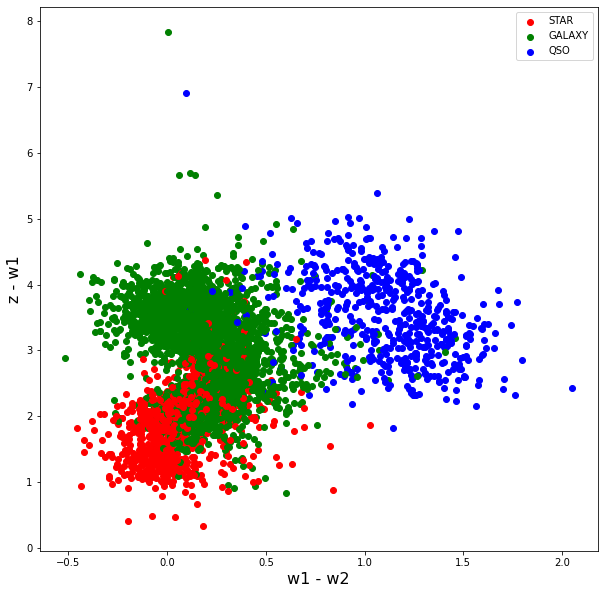

In [19]:
# create a figure and axis
fig, ax = pl.subplots(figsize=(10,10))
labels = ["r","u - g","g - r","r - i","i - z","z - w1","w1 - w2"]
nlabels = len(labels)

# select two random features
ilabels = np.random.choice(nlabels,2)

# defining specific colours for each class
colors = {'STAR':'r', 'GALAXY':'g', 'QSO':'b'}

# plot each data point for each class
#naxis = len(x.shape[1])
for i in range(len(x[:,0])):
    ax.scatter(x[:,ilabels[0]][i], x[:,ilabels[1]][i],label=subset_data['specclass'][i],color=colors[subset_data['specclass'][i]])
# set a title and labels
#ax.set_title('Iris Dataset')
ax.set_xlabel(labels[ilabels[0]])
ax.set_ylabel(labels[ilabels[1]])
handles, labels = pl.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
pl.legend(by_label.values(), by_label.keys())

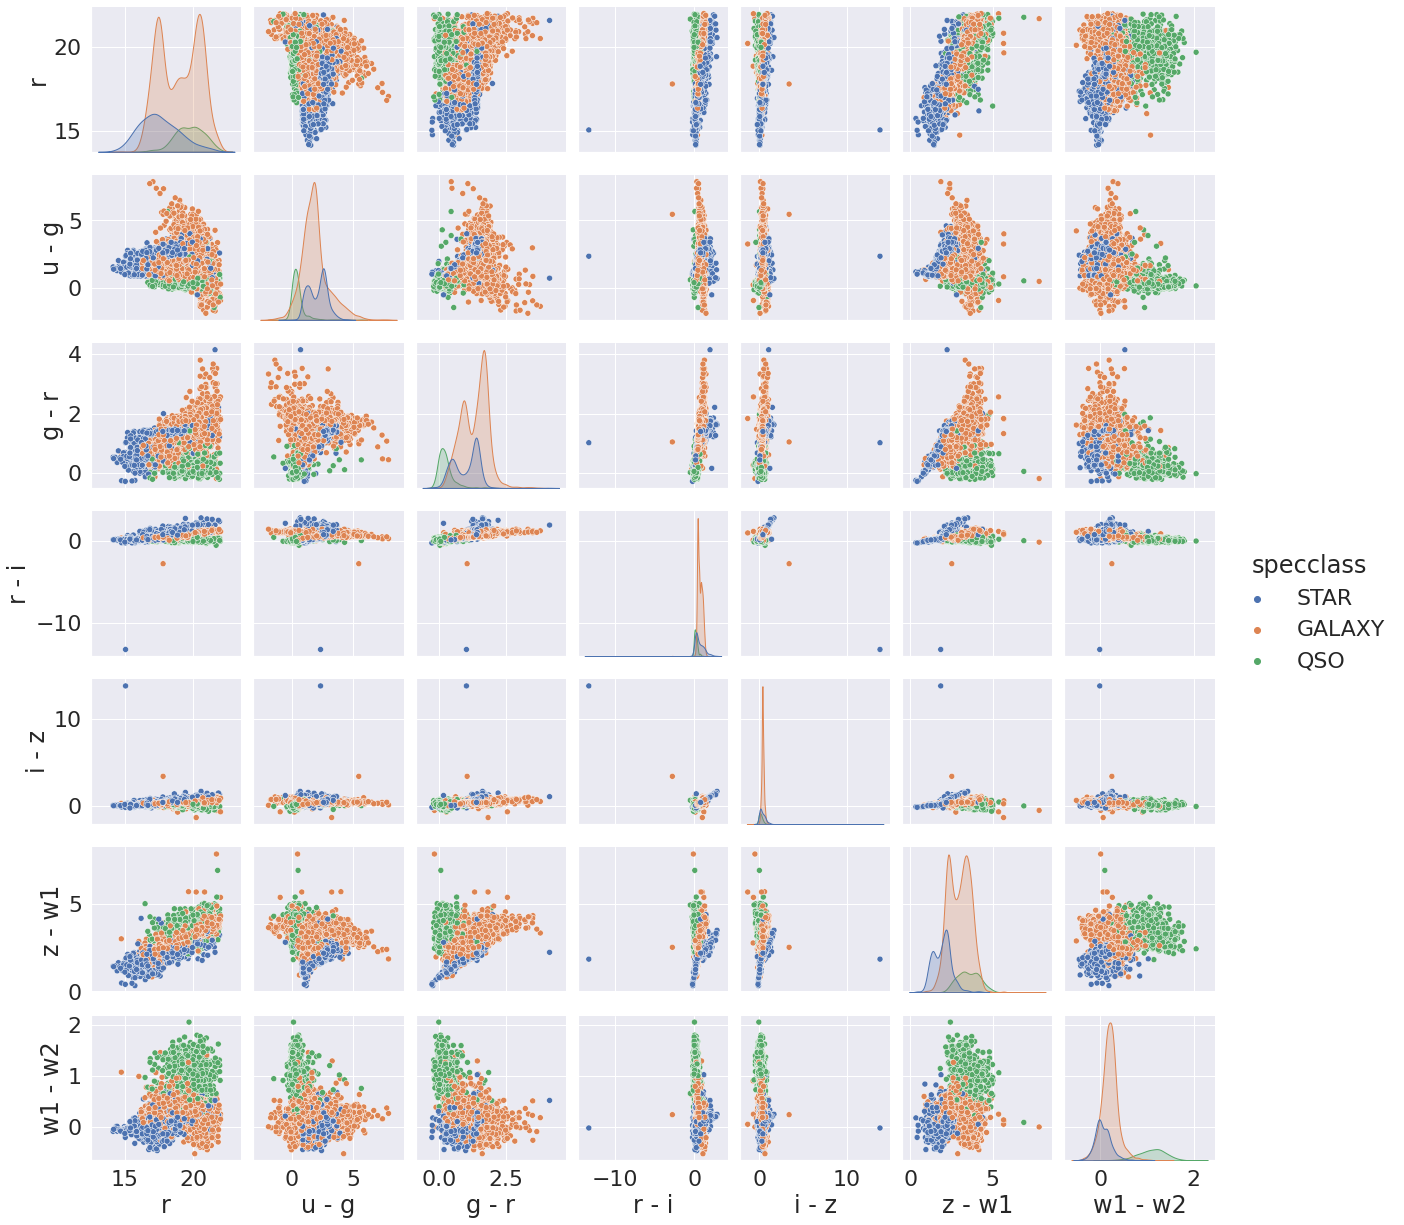

In [20]:
import seaborn as sns
sns.set(font_scale=2)
sns.pairplot(df, hue="specclass",)

# Classification

Classification is a process of grouping objects according to
shared properties and is applied to help understand the origin and evolution of the
objects under consideration. It can be performed using different observed properties of objects, properties like colour, morphology or size. For instance, in this tutorial to follow, classification is performed differentiate between three classes of [astronomical sources](https://en.wikipedia.org/wiki/Astronomical_object) (stars, galaxies, quasars) using colour properties derived from photometric magnitudes. </br>

### preprocessing the data for classification

In [21]:
# preprocess the data
x_train, x_test, y_train, y_test, i_train, i_test = Preprocessing(file,'C',N=N_all)

In [22]:
# combine test and training labels
y_all = np.concatenate((y_train,y_test), axis=None)
y_all

array([0, 0, 2, ..., 2, 2, 0])

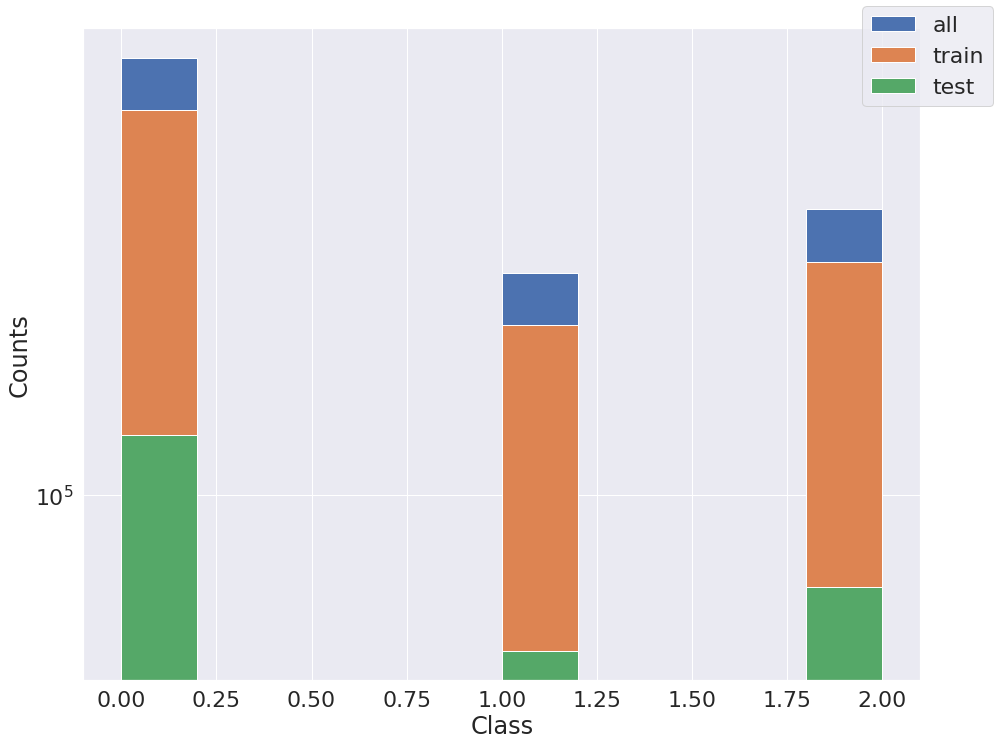

In [23]:
# distribution of all classes in different datasets
# 0: Galaxy, 1: Star and 2: Quasar
pl.figure(figsize=(15,12))
pl.hist(y_all,label='all')
pl.hist(y_train, label='train')
pl.hist(y_test, label='test')
pl.xlabel('Class')
pl.ylabel('Counts')
pl.yscale("log")
pl.legend(bbox_to_anchor=(1.1, 1.05))

In [24]:
df["specclass"].values

array(['STAR', 'STAR', 'GALAXY', ..., 'GALAXY', 'GALAXY', 'STAR'],
      dtype=object)

In [25]:
y = np.where(df["specclass"].values=='GALAXY',0,df["specclass"].values)
y = np.where(y=='STAR',1,y)
y = np.where(y=='QSO',2,y)
y = y.astype(int) # need to change the array to int type from object type 
                  # to avoid errors when performing hyperparameter optimizatino 

In [26]:
y

array([1, 1, 0, ..., 0, 0, 1])

### hyperparameter optimization for classification

In [27]:
# This hyperparameter optimization example is from 
# https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


# define model
model = KNeighborsClassifier()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['n_neighbors'] = np.arange(10,100,10)
space['weights'] = ['uniform','distance']
space['algorithm'] = ['auto','ball_tree','kd_tree','brute']
space['leaf_size'] = np.arange(10,100,10)
space['metric'] = ['euclidean','chebyshev','manhattan','minkowski']

# define search
#search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(x, y)
#result = search.fit(x_train, y_train) # to use full training dataset (PS: this process takes few hours to finish)
 
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9718666666666667
Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


In [28]:
#kNearestNeighbor
# using 10 nearest neighbors
model_knn = KNeighborsClassifier(algorithm=result.best_params_['algorithm'], leaf_size=result.best_params_['leaf_size'], n_neighbors=result.best_params_['n_neighbors'], metric=result.best_params_['metric'], weights=result.best_params_['weights'])

y_pred_knn, probability_knn = classifier(model_knn, x_train, x_test, y_train, y_test,"knn")

Elapsed time for knn: 78.41872260533273 seconds
Accuracy for knn is: 0.9806083803384368
              precision    recall  f1-score   support

      GALAXY     0.9822    0.9830    0.9826    129039
        STAR     0.9765    0.9766    0.9765     51546
         QSO     0.9808    0.9792    0.9800     67615

    accuracy                         0.9806    248200
   macro avg     0.9798    0.9796    0.9797    248200
weighted avg     0.9806    0.9806    0.9806    248200



In [29]:
model = RandomForestClassifier()
# define evaluation
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['n_estimators'] = np.arange(10,100,10)
space['criterion'] = ['gini','entropy']
space['max_features'] = ['auto','sqrt','log2']

# define search
#search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(x, y)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.9782666666666667
Best Hyperparameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 40}


In [30]:
# RandomForest
# using 30 decision trees
model_rf = RandomForestClassifier(n_estimators=result.best_params_['n_estimators'], criterion=result.best_params_['criterion'], max_features=result.best_params_['max_features'])

y_pred_rf, probability_rf, importance = classifier(model_rf, x_train, x_test, y_train, y_test,"rf")

Elapsed time for rf: 259.11396016925573 seconds
Accuracy for rf is: 0.9839605157131346
              precision    recall  f1-score   support

      GALAXY     0.9837    0.9877    0.9857    129039
        STAR     0.9866    0.9811    0.9838     51546
         QSO     0.9825    0.9790    0.9808     67615

    accuracy                         0.9840    248200
   macro avg     0.9842    0.9826    0.9834    248200
weighted avg     0.9840    0.9840    0.9840    248200



### evaluating the performance of the classifiers

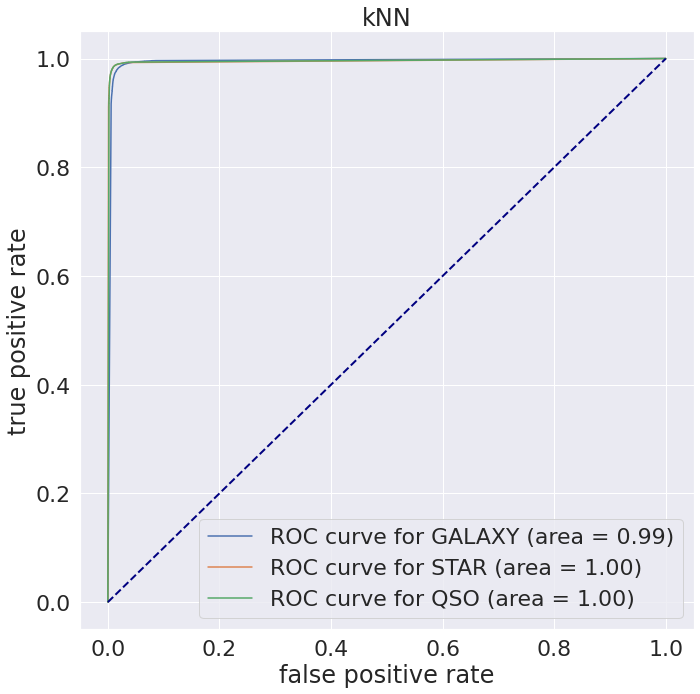

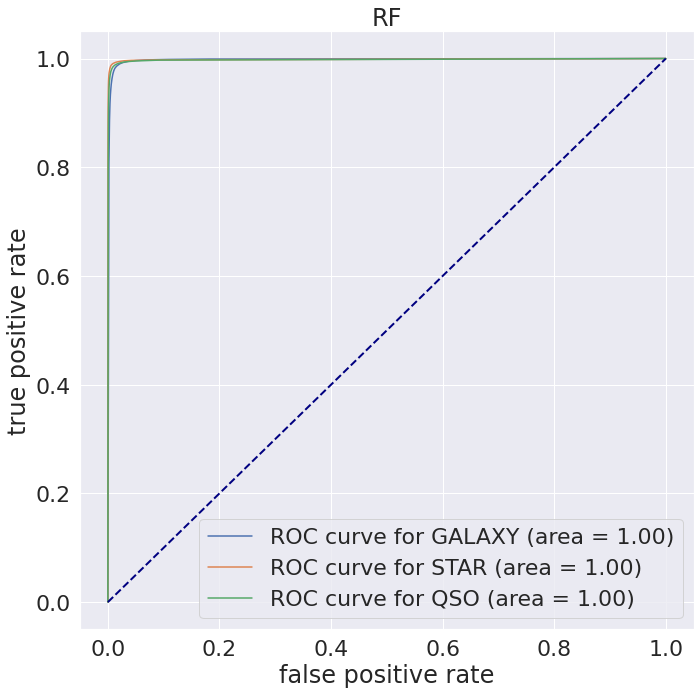

In [31]:
# ROC curve
roc_curve(y_test, probability_knn, 'kNN') #kNN roc_curve

roc_curve(y_test, probability_rf, 'RF') #RF roc_curve

Confusion matrix, without normalization
[[126839   1134   1066]
 [   975  50340    231]
 [  1329     78  66208]]
Normalized confusion matrix
[[0.98 0.01 0.01]
 [0.02 0.98 0.  ]
 [0.02 0.   0.98]]


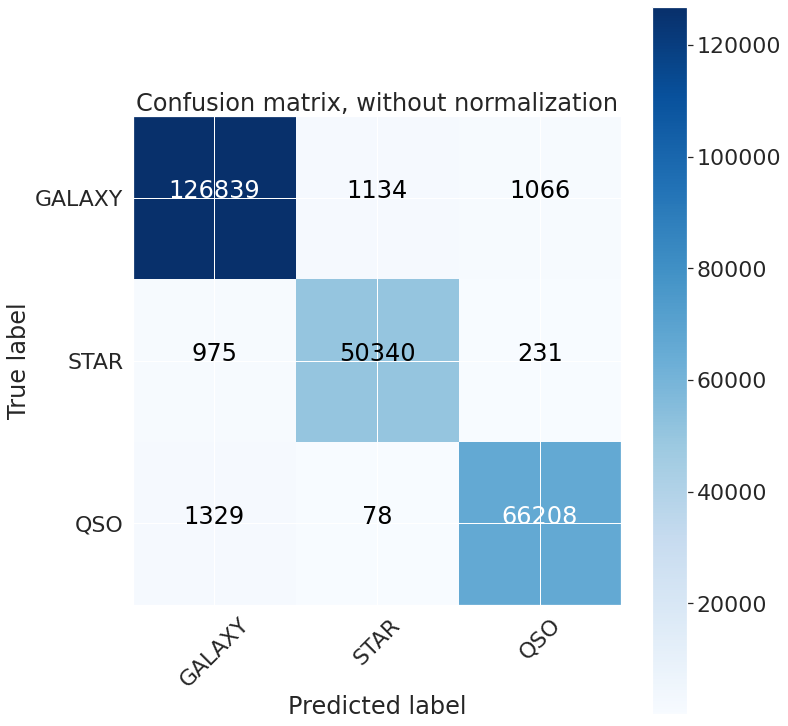

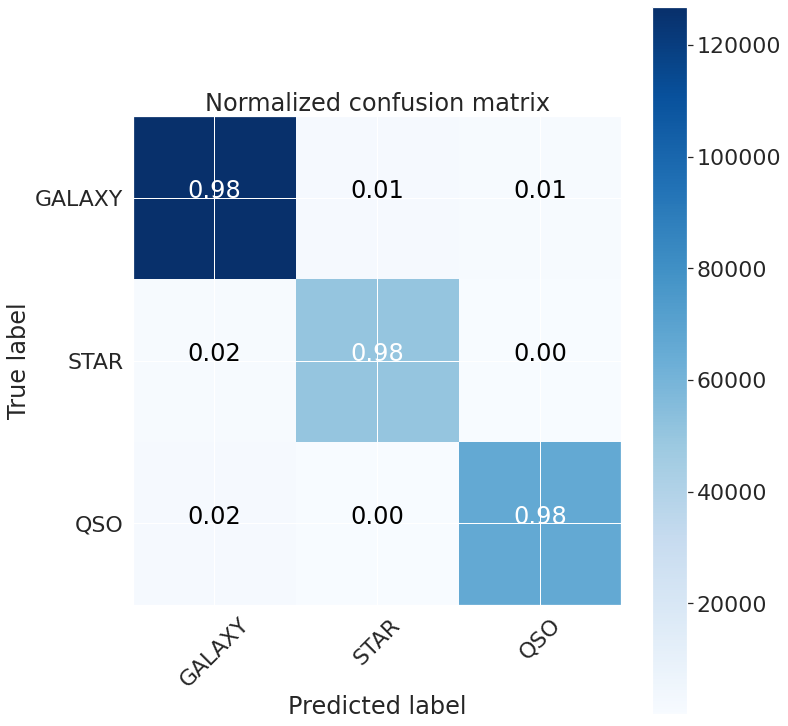

In [32]:
# Compute confusion matrix for kNN classifier
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_knn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix`
pl.figure(figsize=(11,11))
plot_confusion_matrix(cnf_matrix, classes=['GALAXY','STAR','QSO'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
pl.figure(figsize=(11,11))
plot_confusion_matrix(cnf_matrix,classes=['GALAXY','STAR','QSO'], normalize=True,
                      title='Normalized confusion matrix')

Confusion matrix, without normalization
[[127450    606    983]
 [   777  50571    198]
 [  1335     82  66198]]
Normalized confusion matrix
[[0.99 0.   0.01]
 [0.02 0.98 0.  ]
 [0.02 0.   0.98]]


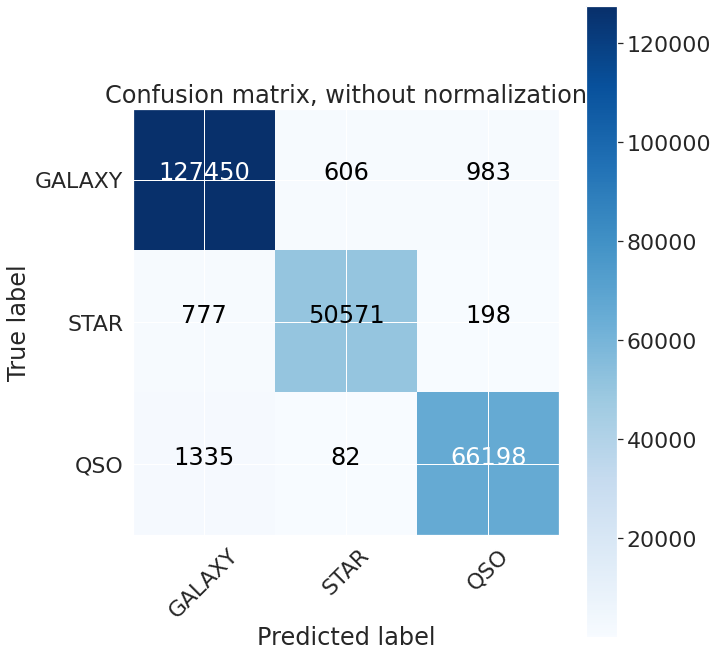

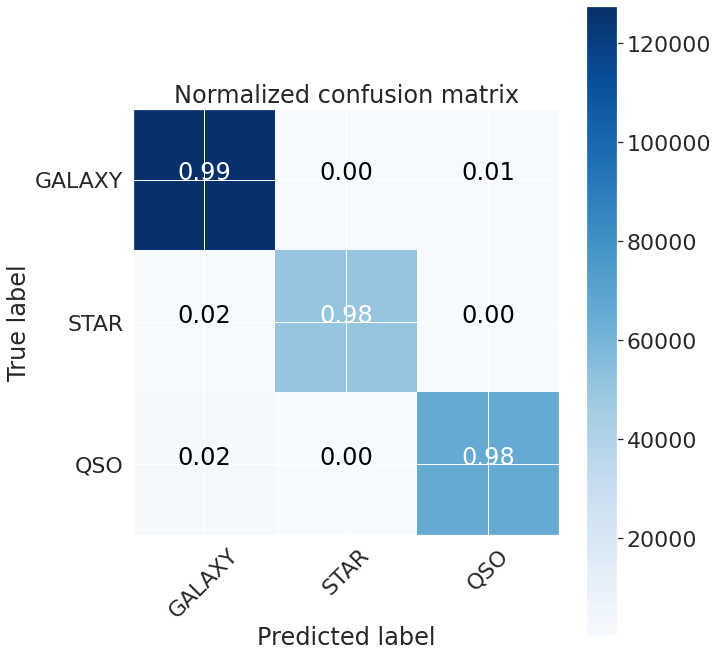

In [33]:
# Compute confusion matrix for Rf classifier
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix`
pl.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=['GALAXY','STAR','QSO'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
pl.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix,classes=['GALAXY','STAR','QSO'], normalize=True,
                      title='Normalized confusion matrix')

### feature importance



Accuracy for RF (feature selection): 0.8880056406124094
              precision    recall  f1-score   support

      GALAXY     0.8848    0.9077    0.8961    129039
        STAR     0.8093    0.7522    0.7797     51546
         QSO     0.9498    0.9539    0.9519     67615

    accuracy                         0.8880    248200
   macro avg     0.8813    0.8713    0.8759    248200
weighted avg     0.8868    0.8880    0.8871    248200

1. feature 6 (0.281493)
2. feature 1 (0.162934)
3. feature 3 (0.162408)
4. feature 5 (0.137714)
5. feature 2 (0.099875)
6. feature 0 (0.081188)
7. feature 4 (0.074388)


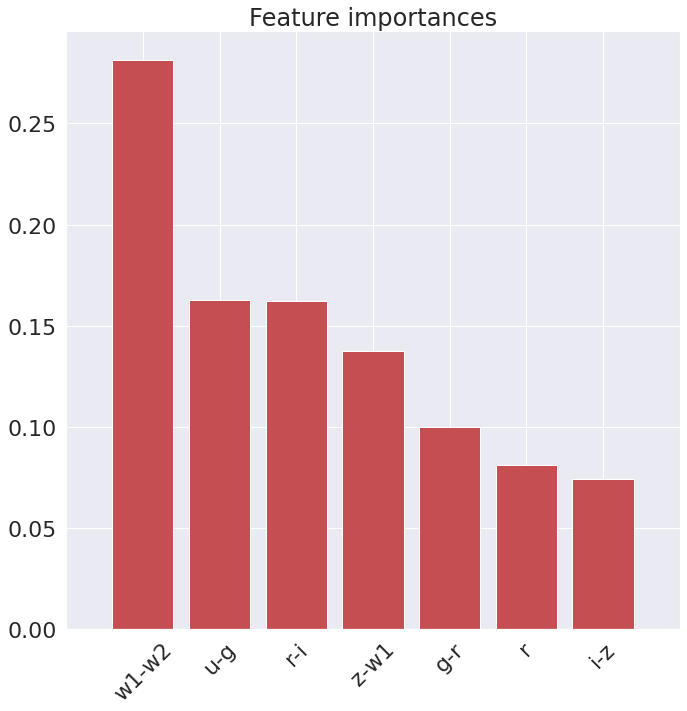

In [34]:
feature_importance(model_rf,importance,x_train, x_test, y_train, y_test)

# Regression

Regression is defined as a measure of the relation between the values one variable (e.g. output) and corresponding values of other variable(s). In astronomy, regression is popular for mapping the relation between the redshift and the measured properties of the given astronomical source. For instance, in the tutorial to follow, the focus is on the relation between the photometric and the spectroscopic redshifts of the two classes: starforming galaxies (SFGs) and quasars (QSOs).

[Photometric redshift](https://en.wikipedia.org/wiki/Photometric_redshift) (photo-z) is a quantity measured by passing light from a given source through a number of standard broad band filters, the intensity through these different filters is then used to determine the redshift. On the other hand, spectroscopic redshift (spec-z) is measured using the spectral lines observed from the source's spectrum and the measuring the shift in frequency or wavelength of the observed emission/absorption line.</br>

Due to the fact that spectroscopic measurements can be expensive and a high wavelength resolution spectrograph is required to be able to accurately identify the lines. Also, spectroscopic measurements are limited by the faint sources. One of the main advantages of the photometric measurements is that the broad band flux measurements of all identified sources from imaging surveys can be used to estimate the photo-z of the given source. As a result, because of the complementary nature betweem photo- and spec-z, astronomers usually study large samples of photo-z estimates available, allowing for statistical anyalysis to be carried out.

### visualizing colour-colour plot as a function of spectroscopic redshift

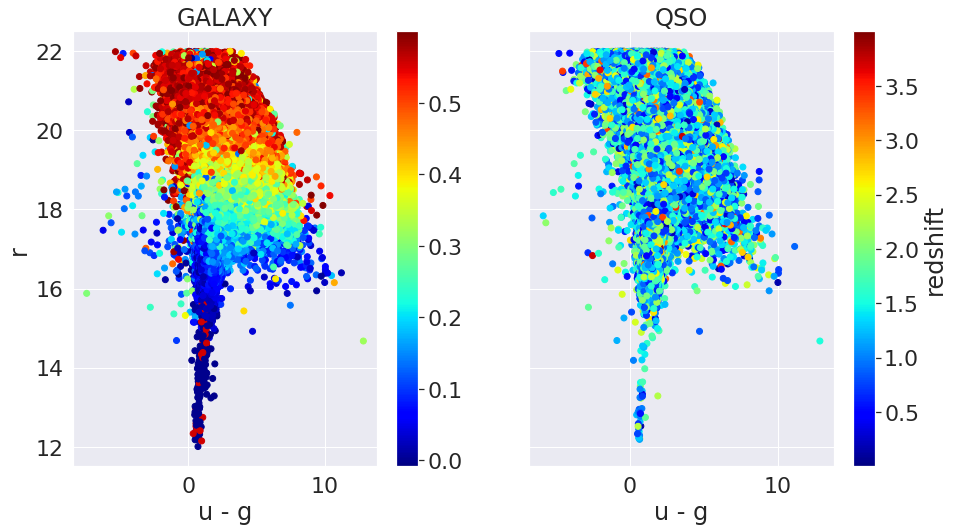

In [35]:
# create a figure and axis
labels = ["r","u - g","g - r","r - i","i - z","z - w1","w1 - w2"]
nlabels = len(labels)

# select two random features
ilabels = np.random.choice(nlabels,2)

df = data[:N_all]

u = df['dered_u']
g = df['dered_g']
r = df['dered_r']
i = df['dered_i']
z = df['dered_z']
w1 = df['w1mpro']
w2 = df['w2mpro']
   
    
#Splitting photometric data into test and train data
x = np.vstack([np.array(r), 
               np.array(u) - np.array(g), 
               np.array(g) - np.array(r), 
               np.array(r) - np.array(i), 
               np.array(i) - np.array(z), 
               np.array(z) - np.array(w1), 
               np.array(w1) - np.array(w2)]).T

# select GALAXY and QSO datasets only
i_gal = np.where(df['specclass']=='GALAXY')[0]
gal = x[i_gal] # GALAXY features
z_gal = df['zspec'][i_gal] # GALAXY spectroscopic redshifts

limit_z_gal = np.where(z_gal < 0.6)[0]
subset_z_gal = z_gal[limit_z_gal]
subset_gal = gal[limit_z_gal]

i_qso = np.where(df['specclass']=='QSO')[0]
qso = x[i_qso] # QSO features
z_qso = df['zspec'][i_qso] # QSO spectroscopic redshifts

limit_z_qso = np.where(z_qso < 4)[0]
subset_z_qso = z_qso[limit_z_qso]
subset_qso = gal[limit_z_qso]

# plot data points
fig, ax = pl.subplots(1,2,sharey=True,figsize=(15,8))

ax[0].set_title('GALAXY')
p = ax[0].scatter(subset_gal[:,ilabels[0]], subset_gal[:,ilabels[1]], c=subset_z_gal, cmap='jet') 

ax[0].set_xlabel(labels[ilabels[0]])
ax[0].set_ylabel(labels[ilabels[1]])
pl.colorbar(p,ax=ax[0])

ax[1].set_title('QSO')

p1 = ax[1].scatter(subset_qso[:,ilabels[0]], subset_qso[:,ilabels[1]], c=subset_z_qso, cmap='jet')
ax[1].set_xlabel(labels[ilabels[0]])
pl.colorbar(p1,ax=ax[1], label='redshift')


### preprocessing the data for photo-z regression

In [36]:
x_data, y_data,i_gal, i_qso = Preprocessing(file, 'r', N=N_all)

Number of galaxies: 645196


Number of quasars: 338073


### redshift distribution of the dataset

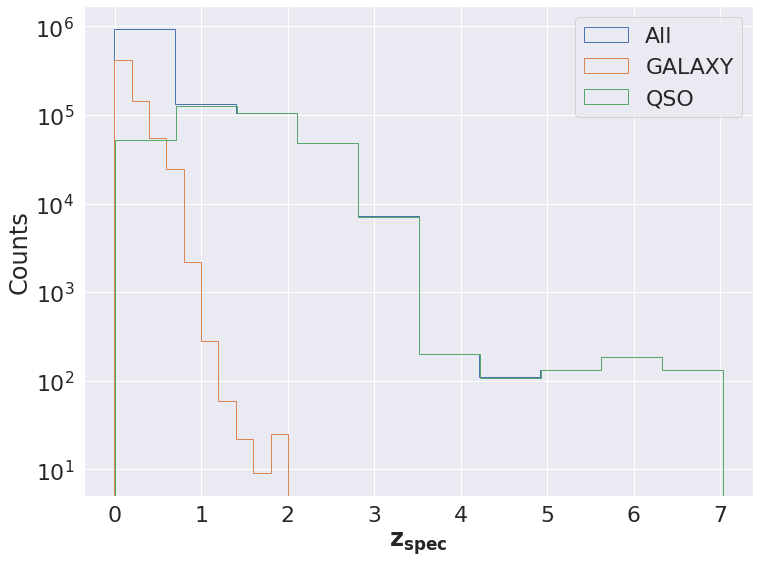

In [40]:
pl.figure(figsize=(12,9))
pl.hist(y_data,log=True,histtype='step',label='All')
pl.hist(y_data[i_gal],log=True,histtype='step',label='GALAXY')
pl.hist(y_data[i_qso],log=True,histtype='step',label='QSO')
pl.xlabel(r'$\mathbf{z_{spec}}$')
pl.ylabel('Counts')
pl.legend()

### hyperparameter estimation for photo-z regression

In [51]:
# model = KNeighborsRegressor()

# space = dict()
# space['n_neighbors'] = np.arange(10,100,10)
# space['weights'] = ['uniform','distance']
# space['algorithm'] = ['auto','ball_tree','kd_tree','brute']
# space['leaf_size'] = np.arange(10,100,10)
# space['metric'] = ['euclidean','chebyshev','manhattan','minkowski']

# # define search
# #search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5)

# subset_indices = np.random.choice(subset_gal.shape[0], size=5000, replace=False)

# x_subset = subset_gal[subset_indices, :]
# y_subset = subset_z_gal[subset_indices]

# # execute search
# result = search.fit(x_subset, y_subset)
# #result = search.fit(x_train, y_train) # to use full training dataset (PS: this process takes few hours to finish)
 
# # summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -0.02761816951473075
Best Hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


In [41]:
# kNearestRegressor
# using 10 nearest neighbors 
#kg = KNeighborsRegressor(n_neighbors=result.best_params_['n_neighbors'], weights=result.best_params_['weights'], algorithm=result.best_params_['algorithm'],leaf_size=result.best_params_['leaf_size'],metric=result.best_params_['metric'])
kg = KNeighborsRegressor(10)

Galaxy photo-z

delta(z)_mean = 0.0002726178790908307; delta(z)_median = 7.242545689223334e-05; sigma(delta(z)) = 0.027772678062319756; nmad(delta(z)) = 0.016168140183202923
sigma1 = 15.297057018332413; sigma2 = 3.300082455563891; sigma3 = 1.2281539253188178; sigma0.15 = 0.3942987867252742

QSO photo-z

delta(z)_mean = 0.015400425530970097; delta(z)_median = 0.002434714697301388; sigma(delta(z)) = 0.14051751792430878; nmad(delta(z)) = 0.05317033600956201
sigma1 = 12.44217276588696; sigma2 = 5.2721873188277195; sigma3 = 2.5591878749156995; sigma0.15 = 11.565446822607935


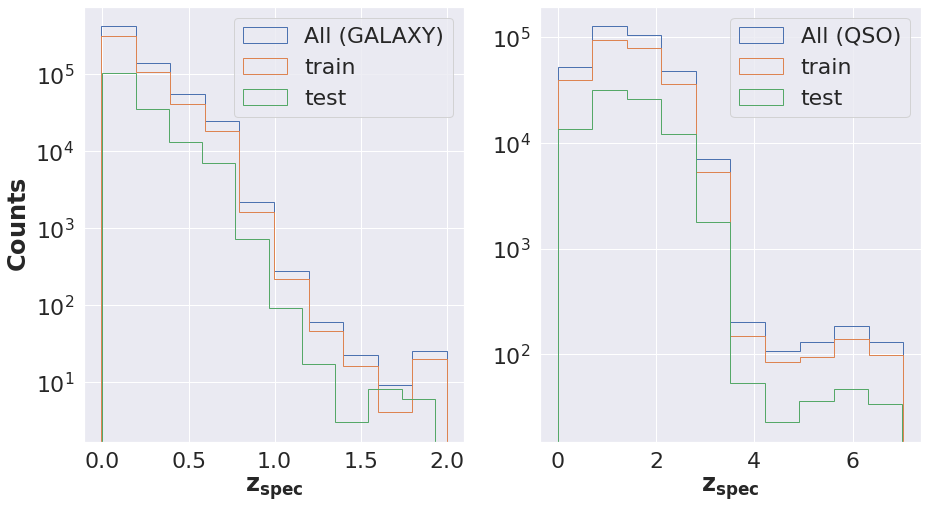

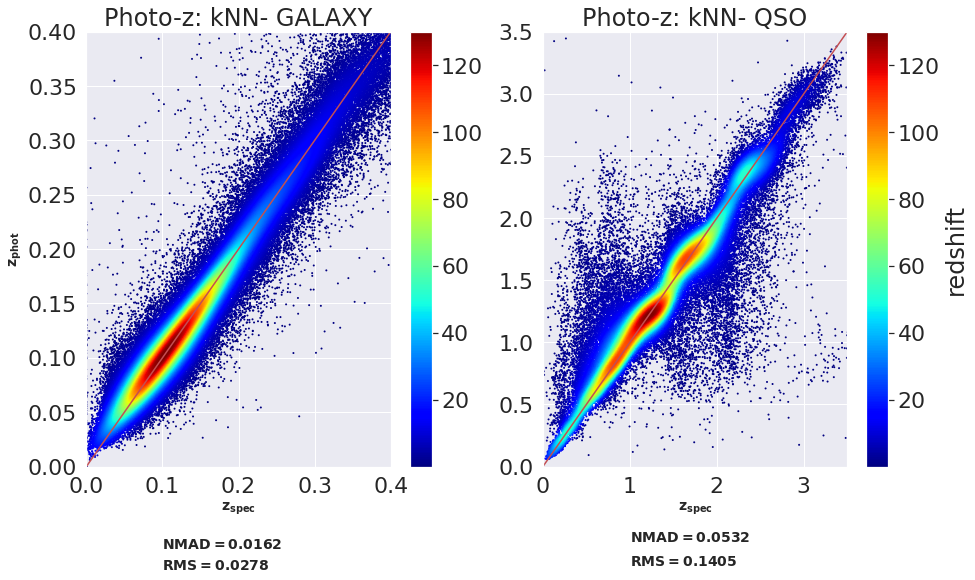

In [42]:
regressor(kg,x_data,y_data, i_gal, i_qso, 'kNN', show_distribution=True, density_plot=True, lim1=[[0.0,0.4],[0.0,0.4]],lim2=[[0.0,3.5],[0.0,3.5]])

Galaxy photo-z

delta(z)_mean = 0.0002726178790908307; delta(z)_median = 7.242545689223334e-05; sigma(delta(z)) = 0.027772678062319756; nmad(delta(z)) = 0.016168140183202923
sigma1 = 15.297057018332413; sigma2 = 3.300082455563891; sigma3 = 1.2281539253188178; sigma0.15 = 0.3942987867252742

QSO photo-z

delta(z)_mean = 0.015400425530970097; delta(z)_median = 0.002434714697301388; sigma(delta(z)) = 0.14051751792430878; nmad(delta(z)) = 0.05317033600956201
sigma1 = 12.44217276588696; sigma2 = 5.2721873188277195; sigma3 = 2.5591878749156995; sigma0.15 = 11.565446822607935


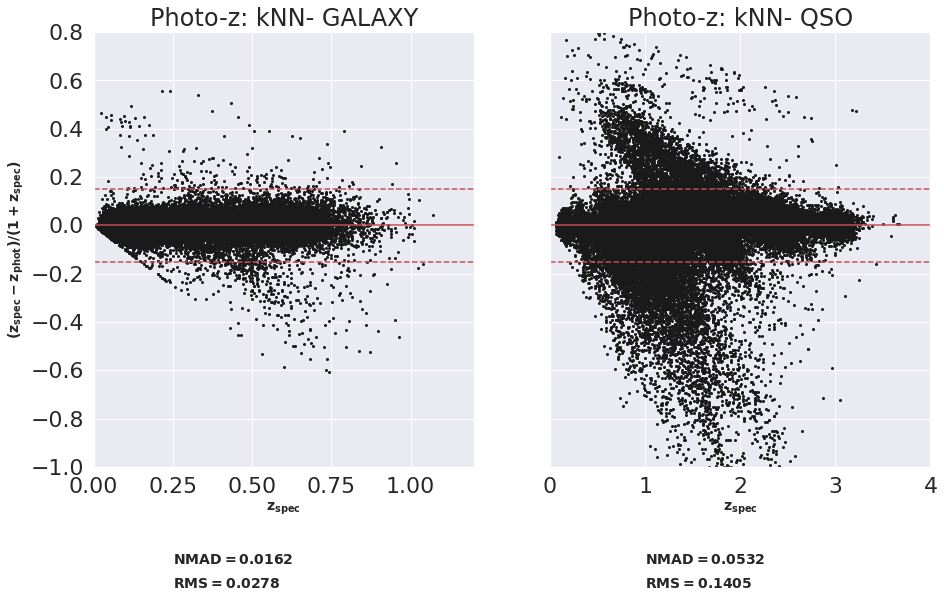

In [43]:
regressor(kg,x_data,y_data, i_gal, i_qso, 'kNN', normed=True, lim1=[[0.0,1.20],[-1.0,0.80]],lim2=[[0.0,4.0],[-1.0,0.80]])

In [57]:
### RandomForestRegressor
# model = RandomForestRegressor()

# space = dict()
# space['n_estimators'] = np.arange(10,100,10)
# space['criterion'] = ['mse','mae']
# space['max_features'] = ['auto','sqrt','log2']

# # define search
# #search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# search = GridSearchCV(model, space, scoring='neg_mean_absolute_error', n_jobs=-1, cv=5)

# subset_indices = np.random.choice(subset_qso.shape[0], size=5000, replace=False)

# x_subset = subset_qso[subset_indices, :]
# y_subset = subset_z_qso[subset_indices]

# # execute search
# result = search.fit(x_subset, y_subset)
# #result = search.fit(x_train, y_train) # to use full training dataset (PS: this process takes few hours to finish)
 
# # summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -0.564039618187258
Best Hyperparameters: {'criterion': 'mae', 'max_features': 'sqrt', 'n_estimators': 80}


In [44]:
#rfg = RandomForestRegressor(n_estimators=result.best_params_['n_estimators'],criterion=result.best_params_['criterion'],max_features=result.best_params_['max_features'])
rfg = RandomForestRegressor(30)

Galaxy photo-z

delta(z)_mean = 0.0008051672102873002; delta(z)_median = 0.0004626400540151463; sigma(delta(z)) = 0.02779233448055789; nmad(delta(z)) = 0.014881402590111828
sigma1 = 13.862454199964041; sigma2 = 3.0942535291601314; sigma3 = 1.2021153261954507; sigma0.15 = 0.39739861995424647

QSO photo-z

delta(z)_mean = 0.019460703655402756; delta(z)_median = 0.004773362944467602; sigma(delta(z)) = 0.14736346191395922; nmad(delta(z)) = 0.05260699519824264
sigma1 = 11.991386552136206; sigma2 = 5.074598610963215; sigma3 = 2.3521338397283453; sigma0.15 = 11.745288041742095


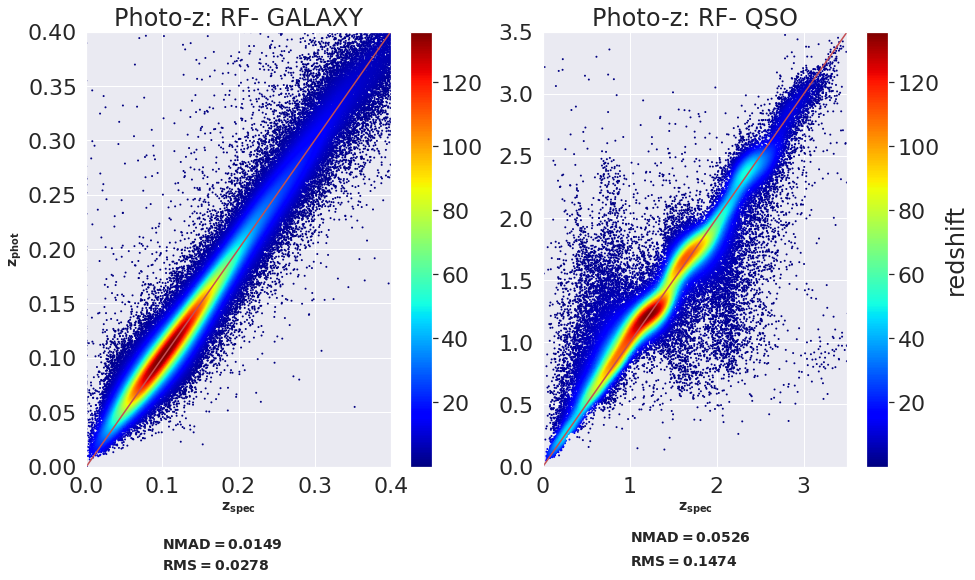

In [45]:
regressor(rfg,x_data,y_data, i_gal, i_qso, 'RF', density_plot=True, lim1=[[0.0,0.4],[0.0,0.4]],lim2=[[0.0,3.5],[0.0,3.5]])

Galaxy photo-z

delta(z)_mean = 0.0007728328045002419; delta(z)_median = 0.00043766197943957783; sigma(delta(z)) = 0.02765407371962689; nmad(delta(z)) = 0.014871397246404582
sigma1 = 13.975288129498633; sigma2 = 3.136411261074154; sigma3 = 1.2064550927160118; sigma0.15 = 0.4066981196411633

QSO photo-z

delta(z)_mean = 0.019516654173711605; delta(z)_median = 0.0048096292200396126; sigma(delta(z)) = 0.14764770297285107; nmad(delta(z)) = 0.05274688682703441
sigma1 = 12.029247861427608; sigma2 = 5.00242549012648; sigma3 = 2.3462180101515635; sigma0.15 = 11.826926489901679


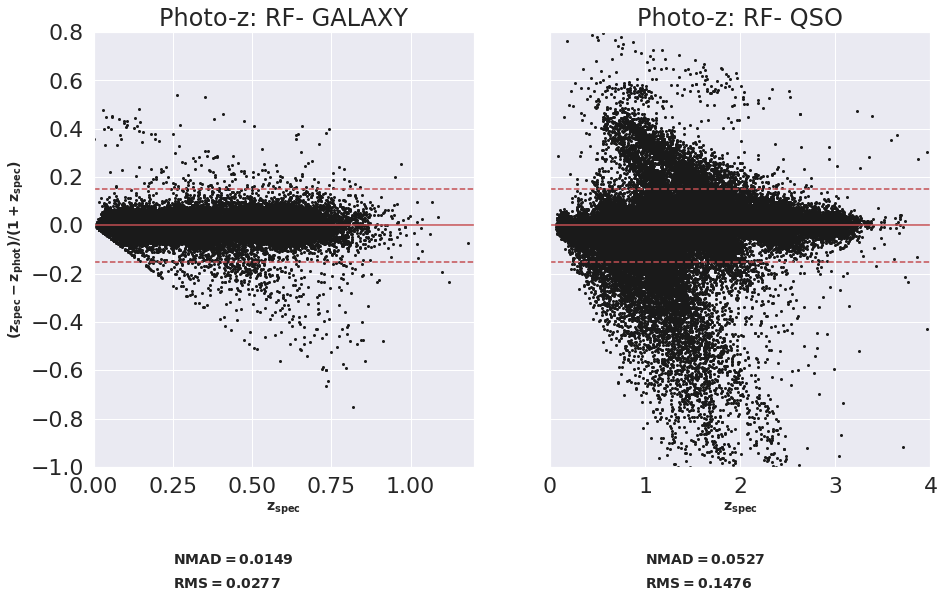

In [48]:
regressor(rfg,x_data,y_data, i_gal, i_qso, 'RF', normed=True, lim1=[[0.0,1.20],[-1.0,0.80]],lim2=[[0.0,4.0],[-1.0,0.80]])

Todos:

- 